# 3D Convolutions for track finding

In this notebook we try 3D convolution instead of LSTM for classifying pixels, etc.

The detector is, as before, composed of square 2D layers.
I generate straight tracks that pass through every layer and leave hits deterministically.

In [1]:
# System imports
import math
from __future__ import print_function

# External imports
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
import keras.backend as K
from keras.regularizers import l2

# Local imports
from metrics import calc_hit_accuracy
from toydata import generate_data, track_hit_coords
from drawing import draw_layers, draw_projections, draw_train_history

# Magic
%matplotlib notebook

Using TensorFlow backend.


In [2]:
# Set random seed
np.random.seed(2017)

## Data generation

In [3]:
# Configuration
#num_event = 102400
num_det_layers = 10
det_layer_size = 32
num_seed_layers = 3
avg_bkg_tracks = 3
noise_prob = 0.01
det_shape = (num_det_layers, det_layer_size, det_layer_size)

In [4]:
def batch_generator(num_batch, det_shape=det_shape,
                    num_seed_layers=num_seed_layers,
                    avg_bkg_tracks=avg_bkg_tracks,
                    noise_prob=noise_prob):
    """Generator of toy data batches for training"""
    shape = (num_batch,) + det_shape
    while True:
        events, sig_tracks, _ = generate_data(
            shape, num_seed_layers=num_seed_layers,
            avg_bkg_tracks=avg_bkg_tracks,
            noise_prob=noise_prob, verbose=False)
        train_target = sig_tracks.reshape(num_batch, det_shape[0], -1)
        yield (events, train_target)

## Define the model

In [5]:
def build_conv_model(shape, dropout=0, l2reg=0, pool=(1,2,2)):
    """Build the CNN model"""
    inputs = layers.Input(shape=shape)

    # Need a 'channel' dimension for 3D convolution, though we have only 1 channel
    # Theano ordering
    #hidden = layers.Reshape((1,)+shape)(inputs)
    # Tensorflow ordering
    hidden = layers.Reshape(shape+(1,))(inputs)

    # 3D convolutional layers
    conv_args = dict(border_mode='same', activation='relu')
    hidden = layers.Conv3D(8, 3, 3, 3, **conv_args)(hidden)
    #hidden = layers.Conv3D(8, 3, 3, 3, **conv_args)(hidden)
    #hidden = layers.Conv3D(8, 3, 3, 3, subsample=pool, border_mode='same')(hidden)
    #hidden = layers.MaxPooling3D(pool_size=pool)(hidden)
    #hidden = layers.Dropout(dropout)(hidden)
    #hidden = layers.Conv3D(16, 3, 3, 3, **conv_args)(hidden)
    #hidden = layers.Conv3D(16, 3, 3, 3, **conv_args)(hidden)
    #hidden = layers.MaxPooling3D(pool_size=pool)(hidden)
    #hidden = layers.Dropout(dropout)(hidden)
    #hidden = layers.Conv3D(32, 3, 3, 3, **conv_args)(hidden)
    #hidden = layers.MaxPooling3D(pool_size=pool)(hidden)
    #hidden = layers.Dropout(dropout)(hidden)
    #hidden = layers.Conv3D(64, 3, 3, 3, **conv_args)(hidden)
    #hidden = layers.MaxPooling3D(pool_size=pool)(hidden)
    #hidden = layers.Dropout(dropout)(hidden)
    #hidden = layers.Conv3D(96, 3, 2, 2, **conv_args)(hidden)
    #hidden = layers.MaxPooling3D(pool_size=pool)(hidden)
    #hidden = layers.Dropout(dropout)(hidden)
    #hidden = layers.Conv3D(128, 3, 1, 1, **conv_args)(hidden)
    
    # Permute dimensions to group detector layers:
    # Theano ordering (channels, det_layers, w, w) -> (det_layers, channels, w, w)
    # Tensorflow ordering stays the same
    #PermuteLayer = layers.Permute((2, 1, 3, 4))
    #hidden = PermuteLayer(hidden)
    
    # Reshape to flatten each detector layer: (det_layers, -1)
    #perm_shape = PermuteLayer.output_shape
    #flat_shape = (perm_shape[1], np.prod(perm_shape[2:]))
    current_shape = hidden.get_shape()
    flat_shape = (int(current_shape[1]), int(np.prod(current_shape[2:])))
    hidden = layers.Reshape(flat_shape)(hidden)
    
    # Output softmax
    outputs = layers.TimeDistributed(
        layers.Dense(shape[1]*shape[2], activation='softmax',
                     W_regularizer=l2(l2reg)))(hidden)
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='Nadam', metrics=['accuracy'])
    return model

## Training

In [6]:
l2reg = 0.
dropout = 0.

In [7]:
model = build_conv_model(det_shape, l2reg=l2reg, dropout=dropout)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 10, 32, 32)    0                                            
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 10, 32, 32, 1) 0           input_1[0][0]                    
____________________________________________________________________________________________________
convolution3d_1 (Convolution3D)  (None, 10, 32, 32, 8) 224         reshape_1[0][0]                  
____________________________________________________________________________________________________
reshape_2 (Reshape)              (None, 10, 8192)      0           convolution3d_1[0][0]            
___________________________________________________________________________________________

In [8]:
batch_size = 64
num_event = 32000#640000
events_per_epoch = 32000
num_epoch = num_event / events_per_epoch

In [9]:
history = model.fit_generator(batch_generator(batch_size),
                              samples_per_epoch=events_per_epoch,
                              nb_epoch=num_epoch)

Epoch 1/1


InternalError: cuDNN launch failure : input shape([64,1,10,32,32]) filter shape([3,3,3,1,8])
	 [[Node: Conv3D = Conv3D[T=DT_FLOAT, padding="SAME", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/gpu:0"](Reshape, convolution3d_1_W/read)]]
Caused by op 'Conv3D', defined at:
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-186fdb21b16f>", line 1, in <module>
    model = build_conv_model(det_shape, l2reg=l2reg, dropout=dropout)
  File "<ipython-input-5-ff044fc64f69>", line 13, in build_conv_model
    hidden = layers.Conv3D(8, 3, 3, 3, **conv_args)(hidden)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/keras/engine/topology.py", line 514, in __call__
    self.add_inbound_node(inbound_layers, node_indices, tensor_indices)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/keras/engine/topology.py", line 572, in add_inbound_node
    Node.create_node(self, inbound_layers, node_indices, tensor_indices)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/keras/engine/topology.py", line 149, in create_node
    output_tensors = to_list(outbound_layer.call(input_tensors[0], mask=input_masks[0]))
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/keras/layers/convolutional.py", line 1218, in call
    filter_shape=self.W_shape)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 1735, in conv3d
    x = tf.nn.conv3d(x, kernel, strides, padding)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 520, in conv3d
    strides=strides, padding=padding, name=name)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2317, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/sfarrell/software/anaconda2/envs/dlpy3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1239, in __init__
    self._traceback = _extract_stack()


<IPython.core.display.Javascript object>


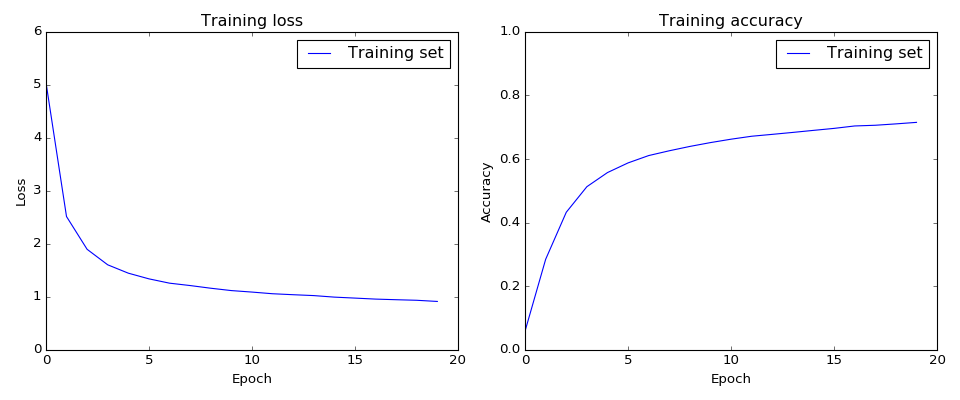

In [20]:
draw_train_history(history, draw_val=False)

## Evaluate results

In [21]:
# Generate a new test dataset
test_num_event = 51200
test_events, test_sigtrks, test_sigparams = generate_data(
    (test_num_event,) + det_shape, num_seed_layers=num_seed_layers,
    avg_bkg_tracks=avg_bkg_tracks, noise_prob=noise_prob)
test_target = test_sigtrks.reshape(test_num_event, num_det_layers, -1)

Sizes of arrays
  events:     2097.15 MB
  sig_tracks: 2097.15 MB
  bkg_tracks: 2097.15 MB
  noise:      524.288 MB
  sig_params: 1.6384 MB


In [22]:
# Run the model on the test set
test_preds = model.predict(test_events, batch_size=batch_size)

In [23]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(test_preds, test_target,
                                   num_seed_layers=num_seed_layers)
# Hit classification accuracy
test_scores = test_preds * test_events.reshape(test_num_event, num_det_layers, -1)
hit_accuracy = calc_hit_accuracy(test_scores, test_target)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Accuracy of predicted pixel: 0.6045200892857143
Accuracy of classified hit:  0.96823046875


Input data example event:


<IPython.core.display.Javascript object>


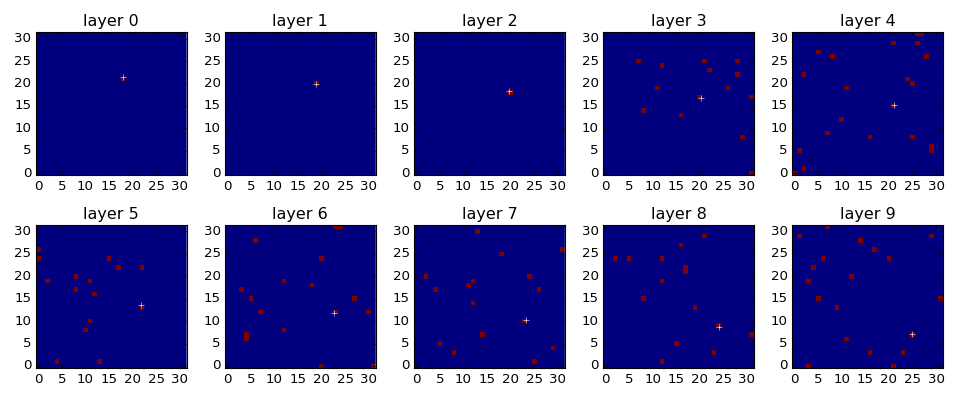

Model prediction:


<IPython.core.display.Javascript object>


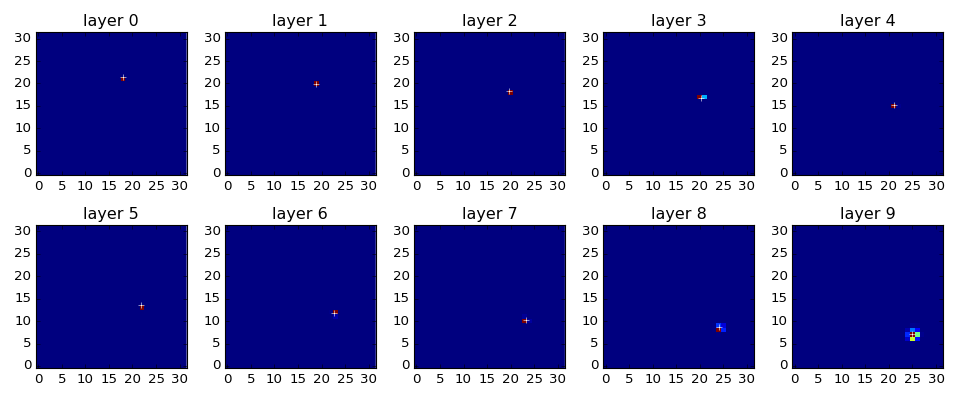

Projected input data:


<IPython.core.display.Javascript object>


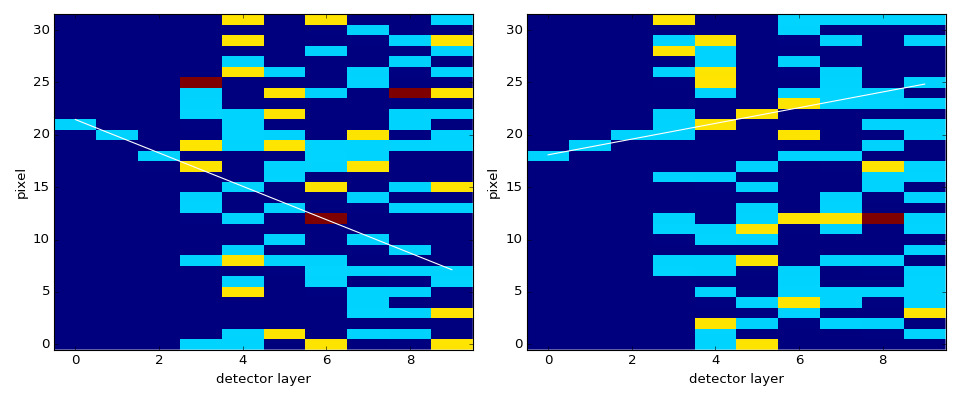

Projected model prediction:


<IPython.core.display.Javascript object>


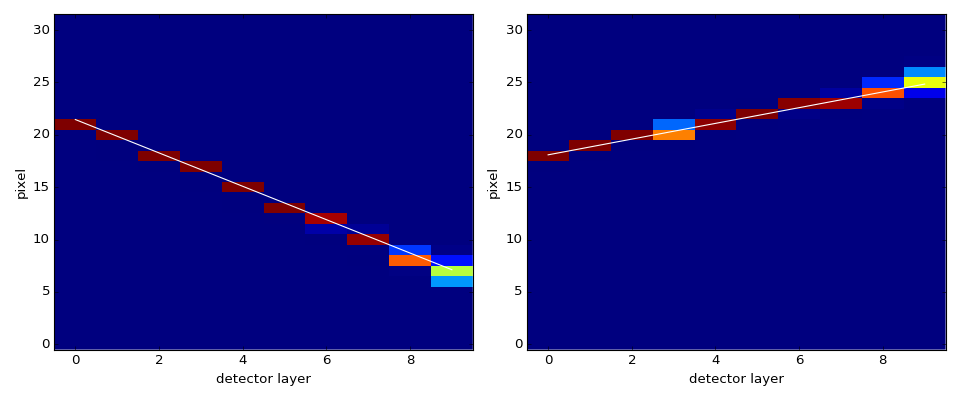

In [24]:
# Select an event to visualize
disp_idx = 1

# Get the hit coordinates for drawing
idx = np.arange(num_det_layers)
xtruth, ytruth = track_hit_coords(test_sigparams[disp_idx],
                                  idx, as_type=np.float32)

# Draw the layers
print('Input data example event:')
draw_layers(test_events[disp_idx], truthx=xtruth, truthy=ytruth)
print('Model prediction:')
draw_layers(test_preds[disp_idx].reshape(det_shape),
            truthx=xtruth, truthy=ytruth)
print('Projected input data:')
draw_projections(test_events[disp_idx], truthx=xtruth, truthy=ytruth)
print('Projected model prediction:')
draw_projections(test_preds[disp_idx].reshape(det_shape),
                 truthx=xtruth, truthy=ytruth)